In [1]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [2]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('GVR Historical Data.csv')

# Đặt lại tên cột
data.columns=[ 'Date', 'Close', 'Open', 'High', 'Low', 'Vol', 'Change']

# data = pd.DataFrame(data)

# Tiền xử lý dữ liệu
data['Date'] = pd.to_datetime(data['Date'])
data['Close'] = data['Close'].apply(lambda x: float(x.replace(",", "")))
data['Open'] = data['Open'].apply(lambda x: float(x.replace(",", "")))
data['High'] = data['High'].apply(lambda x: float(x.replace(",", "")))
data['Low'] = data['Low'].apply(lambda x: float(x.replace(",", "")))
data['Vol'] = data['Vol'].apply(lambda x: float(x.rstrip('M').rstrip('K')) * 1e6 if 'M' in x else float(x.rstrip('K')) * 1e3)

# Sắp xếp dữ liệu tăng dần theo cột Date
data = data.sort_values('Date')

In [3]:
#Xem lại dữ liệu sau khi xử lý hoàn tất
data

,Date,Close,Open,High,Low,Vol,Change
1291,2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.00%
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-3.67%
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-1.90%
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,5.83%
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,5.50%
...,...,...,...,...,...,...,...
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,5.81%
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,1.10%
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-1.09%
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,3.30%


In [4]:
# Chia dữ liệu thành tập huấn luyện, tập validation và tập kiểm tra
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# Tạo ma trận dữ liệu
X_train = train_data[['High', 'Low','Close', 'Open', 'Vol']].values
X_val = val_data[['High', 'Low' , 'Close', 'Open', 'Vol']].values
X_test = test_data[['High', 'Low', 'Close', 'Open', 'Vol']].values

y_train = train_data['Close'].values
y_val = val_data['Close'].values
y_test = test_data['Close'].values


In [6]:
import numpy as np

best_score = float('inf')
best_k_factors = 0
best_factor_order = 0

for k_factors in range(1, 5):
    for factor_order in range(1, 20):
        try:
            # Xây dựng The Dynamic Factor Model
            model = sm.tsa.DynamicFactor(X_train, k_factors=k_factors, factor_order=factor_order)
            result = model.fit()

            # Dự đoán giá cổ phiếu trên tập validation
            y_pred = result.predict(start=train_size, end=train_size+test_size-1)

             # Lấy cột close từ y_pred để tính toán độ chính xác
            y_pred_close = y_pred[:, 2]

            # Đánh giá độ chính xác dự đoán trên tập test
            score = np.mean((y_pred_close - y_test)**2)

            # Lưu lại giá trị tốt nhất
            if score < best_score:
                best_score = score
                best_k_factors = k_factors
                best_factor_order = factor_order

        except np.linalg.LinAlgError as e:
            # Bỏ qua lỗi "LU decomposition error"
            continue

        except ValueError as e:
            if "Non-stationary starting autoregressive parameters" in str(e):
              continue



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [11]:
best_k_factors

3

In [12]:
best_factor_order

2

In [15]:

# Xây dựng The Dynamic Factor Model với giá trị tối ưu
model = sm.tsa.DynamicFactor(X_train, k_factors=best_k_factors, factor_order=best_factor_order)
result = model.fit()
# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_test = result.predict(start=train_size, end=train_size+test_size)

# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_val = result.predict(start=train_size+test_size, end=len(data)-1)

# Dự đoán giá cổ phiếu cho 30 ngày tiếp theo
y_pred_future = result.predict(start=len(data), end=len(data)+29)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


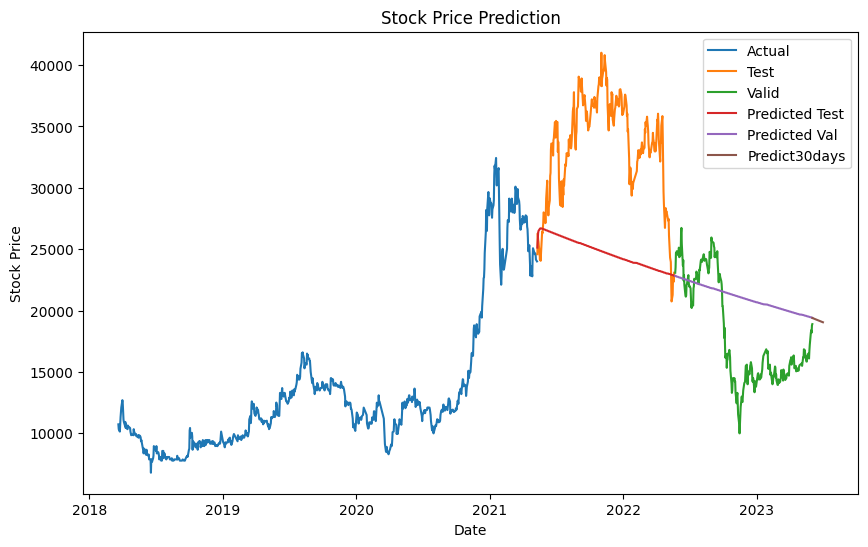

In [16]:

# Vẽ biểu đồ
next_30_days = pd.date_range(start=data['Date'].iloc[-1], periods=30, freq='D')

plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:train_size], train_data['Close'], label='Actual')
plt.plot(data['Date'][train_size:train_size+test_size], test_data['Close'], label='Test')
plt.plot(data['Date'][train_size+test_size:], val_data['Close'], label='Valid')
plt.plot(data['Date'][train_size:train_size+test_size+1], y_pred_test[:,2], label='Predicted Test')
plt.plot(data['Date'][train_size+test_size:], y_pred_val[:,2], label='Predicted Val')
plt.plot(next_30_days, y_pred_future[:, 2], label='Predict30days')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

# Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val[:,2] - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test[1:,2] - y_test)**2))
vail_mape = mean_absolute_percentage_error(y_val, y_pred_val[:,2])
test_mape = mean_absolute_percentage_error(y_test, y_pred_test[1:,2])
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 4695.507658952921
Testing RMSE: 9709.25600329811
Validation MAPE: 0.26393387663891527
Testing MAPE: 0.25170473398099924
